In [15]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load EV charging dataset
ev = pd.read_csv("C:/Users/91821/Downloads/archive (10)/ev_charging_dataset.csv")

# 2) Quick look
print(ev.shape)
print(ev.columns)
print(ev.head())

(64945, 28)
Index(['Date_Time', 'Vehicle_ID', 'Battery_Capacity_kWh', 'State_of_Charge_%',
       'Energy_Consumption_Rate_kWh/km', 'Current_Latitude',
       'Current_Longitude', 'Destination_Latitude', 'Destination_Longitude',
       'Distance_to_Destination_km', 'Traffic_Data', 'Road_Conditions',
       'Charging_Station_ID', 'Charging_Rate_kW', 'Queue_Time_mins',
       'Station_Capacity_EV', 'Time_Spent_Charging_mins', 'Energy_Drawn_kWh',
       'Session_Start_Hour', 'Fleet_Size', 'Fleet_Schedule', 'Temperature_C',
       'Wind_Speed_m/s', 'Precipitation_mm', 'Weekday', 'Charging_Preferences',
       'Weather_Conditions', 'Charging_Load_kW'],
      dtype='object')
             Date_Time  Vehicle_ID  Battery_Capacity_kWh  State_of_Charge_%  \
0  2017-01-01 00:00:00         106             66.746483          50.216524   
1  2017-01-01 01:00:00         106             82.731496          59.358609   
2  2017-01-01 02:00:00         106             82.107913          14.460831   
3  201

In [17]:
# Convert to datetime
ev["Date_Time"] = pd.to_datetime(ev["Date_Time"])

# Sort by time
ev = ev.sort_values("Date_Time")

# Set as index (useful for time-series)
ev = ev.set_index("Date_Time")

# Check missing values
print(ev.isna().sum())

Vehicle_ID                        0
Battery_Capacity_kWh              0
State_of_Charge_%                 0
Energy_Consumption_Rate_kWh/km    0
Current_Latitude                  0
Current_Longitude                 0
Destination_Latitude              0
Destination_Longitude             0
Distance_to_Destination_km        0
Traffic_Data                      0
Road_Conditions                   0
Charging_Station_ID               0
Charging_Rate_kW                  0
Queue_Time_mins                   0
Station_Capacity_EV               0
Time_Spent_Charging_mins          0
Energy_Drawn_kWh                  0
Session_Start_Hour                0
Fleet_Size                        0
Fleet_Schedule                    0
Temperature_C                     0
Wind_Speed_m/s                    0
Precipitation_mm                  0
Weekday                           0
Charging_Preferences              0
Weather_Conditions                0
Charging_Load_kW                  0
dtype: int64


In [18]:
# Aggregate by hour + station
station_hourly = (
    ev.groupby([pd.Grouper(freq="H"), "Charging_Station_ID"])
      .agg({
          "Charging_Load_kW": "sum",
          "Temperature_C": "mean",
          "Precipitation_mm": "mean",
          "Traffic_Data": "mean"
      })
      .reset_index()
)

print(station_hourly.head())

            Date_Time  Charging_Station_ID  Charging_Load_kW  Temperature_C  \
0 2017-01-01 00:00:00                    2         30.839677      13.954368   
1 2017-01-01 01:00:00                    2         47.354691      38.926466   
2 2017-01-01 02:00:00                    2         44.459198      22.164516   
3 2017-01-01 03:00:00                    2         52.468801      16.000845   
4 2017-01-01 04:00:00                    2         53.473756      23.170368   

   Precipitation_mm  Traffic_Data  
0          0.712211           3.0  
1          2.746260           1.0  
2          2.502156           3.0  
3          1.796916           2.0  
4          1.547112           1.0  


C:\Users\91821\AppData\Local\Temp\ipykernel_8052\1629765710.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ev.groupby([pd.Grouper(freq="H"), "Charging_Station_ID"])


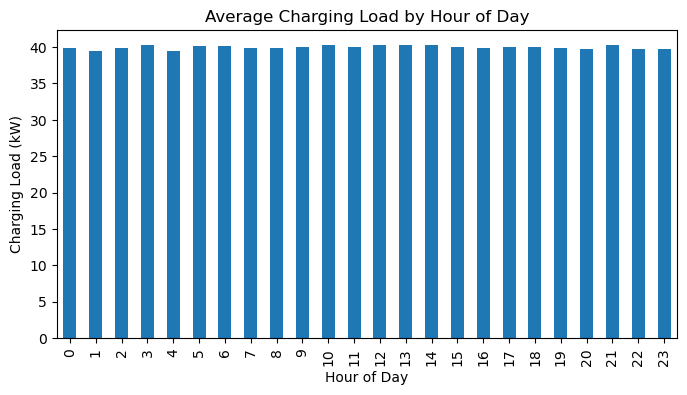

In [19]:
# Make sure Date_Time is datetime
station_hourly["Date_Time"] = pd.to_datetime(station_hourly["Date_Time"])

# Create Hour column
station_hourly["Hour"] = station_hourly["Date_Time"].dt.hour

# Now group by Hour
hourly_pattern = (
    station_hourly
    .groupby("Hour")["Charging_Load_kW"]
    .mean()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
hourly_pattern.plot(kind="bar")
plt.title("Average Charging Load by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Charging Load (kW)")
plt.show()

In [20]:
# Find station with most records
station_counts = station_hourly["Charging_Station_ID"].value_counts()
top_station = station_counts.index[0]
print("Using station:", top_station)

station_ts = station_hourly[station_hourly["Charging_Station_ID"] == top_station].copy()

# Set index again for time-series
station_ts = station_ts.set_index("Date_Time").sort_index()
# Keep only last 90 days
ts_small = ts.last("90D")

y = ts_small["Charging_Load_kW"]
X = ts_small[["Temperature_C", "Precipitation_mm", "Traffic_Data"]]

split_idx = int(len(ts_small) * 0.8)

y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

# Our target
y = station_ts["Charging_Load_kW"]

# Exogenous (weather + traffic)
X = station_ts[["Temperature_C", "Precipitation_mm", "Traffic_Data"]]

Using station: 2


C:\Users\91821\AppData\Local\Temp\ipykernel_8052\882137072.py:11: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  ts_small = ts.last("90D")


In [21]:
split_date = station_ts.index[int(len(station_ts)*0.8)]

y_train = y[y.index <= split_date]
y_test  = y[y.index >  split_date]

X_train = X[X.index <= split_date]
X_test  = X[X.index >  split_date]

print("Train end:", split_date)

Train end: 2022-12-05 20:00:00


In [22]:

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

top_station = station_hourly["Charging_Station_ID"].value_counts().idxmax()

ts = station_hourly[station_hourly["Charging_Station_ID"] == top_station].copy()
ts["Date_Time"] = pd.to_datetime(ts["Date_Time"])
ts = ts.set_index("Date_Time").sort_index()
ts = ts.asfreq("h")

# ---- FAST DATA WINDOW (last 90 days) ----
end_date = ts.index.max()
start_date = end_date - pd.Timedelta(days=90)
ts_small = ts.loc[start_date:end_date]

y = ts_small["Charging_Load_kW"]
X = ts_small[["Temperature_C", "Precipitation_mm", "Traffic_Data"]]

split_idx = int(len(ts_small) * 0.8)

y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False, maxiter=50)
print(results.summary())


C:\Users\91821\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                   Charging_Load_kW   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -6309.345
Date:                            Tue, 16 Dec 2025   AIC                          12634.690
Time:                                    17:39:13   BIC                          12678.088
Sample:                                03-01-2024   HQIC                         12650.767
                                     - 05-11-2024                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Temperature_C       -0.0234      0.027     -0.864      0.388      -0.076       0.030
Precipitation_mm 

In [33]:

forecast = results.predict(
    start=y_test.index[0],
    end=y_test.index[-1],
    exog=X_test
)

ts_forecast = y_test.to_frame(name="Actual_kW")
ts_forecast["Forecast_kW"] = forecast.values
ts_forecast.to_csv("forecast_output.csv")
